In [124]:
import pandas as pd
import os
import glob
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_ind
import itertools
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [125]:
# def get_latest_csv(directory):
#     list_of_files = glob.glob(os.path.join(directory, '*.csv'))
#     if not list_of_files:
#         raise FileNotFoundError("No CSV files found in the directory.")
#     latest_file = max(list_of_files, key=os.path.getmtime)
#     print(f"Using file: {latest_file}")
#     return latest_file

In [126]:
# latest_csv_path = get_latest_csv("llm_results")
# df = pd.read_csv(latest_csv_path)

In [127]:
def get_all_csv(directory):
    # Exclude files containing 'gpt4o' in their name
    list_of_files = [
        f for f in glob.glob(os.path.join(directory, '*.csv'))
        if 'gpt4o' not in os.path.basename(f)
    ]
    if not list_of_files:
        raise FileNotFoundError("No CSV files found in the directory (excluding gpt4o).")
    return list_of_files

def get_avg_result_accross_csv(list_of_files):
    df_list = []
    for file in list_of_files:
        # Extract timestamp using regex
        df_temp = pd.read_csv(file)
        df_temp['timestamp'] = file.split("/")[-1].split("_")[1]
        df_list.append(df_temp)
    combined_df = pd.concat(df_list, ignore_index=True)

    # Compute averages per hypothesis_id and model
    avg_df = combined_df.groupby(['hypothesis_id', 'model'])[['novelty', 'plausibility']].mean().reset_index()
    avg_df.rename(columns={'novelty': 'average_novelty', 'plausibility': 'average_plausibility'}, inplace=True)

    # Calculate std for novelty and plausibility per hypothesis_id and model
    std_df = combined_df.groupby(['hypothesis_id', 'model'])[['novelty', 'plausibility']].std().reset_index()
    std_df.rename(columns={'novelty': 'std_novelty', 'plausibility': 'std_plausibility'}, inplace=True)

    # Merge only the new average columns to keep all original columns
    combined_df = combined_df.merge(
        avg_df[['hypothesis_id', 'model', 'average_novelty', 'average_plausibility']],
        on=['hypothesis_id', 'model'],
        how='left'
    )

    # Merge std values back into the main DataFrame
    combined_df = combined_df.merge(
        std_df,
        on=['hypothesis_id', 'model'],
        how='left'
    )
    return combined_df

# Usage
list_of_files = get_all_csv("llm_results")
df = get_avg_result_accross_csv(list_of_files)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.sort_values(["hypothesis_id", "timestamp", "model"], inplace=True)
# df = df[["hypothesis_id", "model", "average_novelty", "average_plausibility",]]
df.drop_duplicates(inplace=True)

In [128]:
avg_std = df.groupby('model')[['std_novelty', 'std_plausibility']].mean().reset_index()
# avg_std['avg_std'] = avg_std[['std_novelty', 'std_plausibility']].mean(axis=1)

avg_std["std_novelty"] = avg_std["std_novelty"].round(2)
avg_std["std_plausibility"] = avg_std["std_plausibility"].round(2)
print(avg_std)

                                model  std_novelty  std_plausibility
0  anthropic:claude-3-7-sonnet-latest         0.78              0.50
1                      openai:o3-mini         0.83              0.66
2                      openai:o4-mini         0.78              1.00


In [180]:
combine_hyp = pd.read_csv('models_hypotheses/combined_hypotheses.csv')
combine_hyp.rename(columns={'hypo_id': 'hypothesis_id'}, inplace=True)

,hypothesis_id,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,End_Position,upstream_gene_variant,TMB (nonsynonymous),Sex,...,Protein_position,Variant_Type,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank
633,LIFT.PANCREATIC_CANCER.1,Pancreatic Cancer,Chromosome value is 12 AND Hugo_Symbol value i...,Ggt/Cgt,NaN,KRAS,NaN,NaN,NaN,NaN,...,12.0,NaN,NaN,27.03,LIFT,2838.0,missense_variant,25398285.0-25398285.0,Substitution/Indel,1
634,LIFT.BREAST_CARCINOMA.2,Breast Carcinoma,Sex value is Female AND Chromosome value is 3 ...,cAt/cGt,NaN,PIK3CA,NaN,NaN,NaN,Female,...,1047.0,NaN,NaN,26.22,LIFT,238.0,missense_variant,178952085.0-178952085.0,Substitution/Indel,2
635,LIFT.PANCREATIC_CANCER.3,Pancreatic Cancer,Sex value is Female AND Chromosome value is 12...,NaN,NaN,KRAS,NaN,NaN,NaN,Female,...,NaN,NaN,NaN,22.07,LIFT,2837.0,missense_variant,NaN,Substitution/Indel,3
636,LIFT.BREAST_CARCINOMA.4,Breast Carcinoma,Sex value is Female AND Chromosome value is 3 ...,NaN,NaN,PIK3CA,NaN,NaN,NaN,Female,...,NaN,NaN,NaN,22.01,LIFT,236.0,missense_variant,NaN,Substitution/Indel,4
637,LIFT.SMALL_CELL_LUNG_CANCER.5,Small Cell Lung Cancer,Sex value is Male AND Smoke Status value is Sm...,NaN,NaN,RB1,NaN,NaN,NaN,Male,...,NaN,NaN,NaN,20.05,LIFT,3031.0,NaN,NaN,Truncation,5
638,LIFT.INTRAHEPATIC_CHOLANGIOCARCINOMA.6,Intrahepatic Cholangiocarcinoma,Chromosome value is 2 AND Hugo_Symbol value is...,NaN,NaN,IDH1,NaN,NaN,NaN,NaN,...,132.0,NaN,NaN,16.57,LIFT,1990.0,missense_variant,NaN,Substitution/Indel,6
639,LIFT.PANCREATIC_CANCER.7,Pancreatic Cancer,Sex value is Male AND Chromosome value is 12 A...,gGt/gTt,NaN,KRAS,NaN,NaN,NaN,Male,...,12.0,NaN,NaN,16.25,LIFT,2835.0,missense_variant,25398284.0-25398284.0,Substitution/Indel,7
640,LIFT.BREAST_CARCINOMA.8,Breast Carcinoma,Sex value is Female AND Chromosome value is 3 ...,cAt/cGt,NaN,PIK3CA,NaN,NaN,0.100000,Female,...,1047.0,NaN,NaN,14.78,LIFT,230.0,missense_variant,178952085.0-178952085.0,Substitution/Indel,8
641,LIFT.SOFT_TISSUE_SARCOMA.9,Soft Tissue Sarcoma,Sex value is Male AND Chromosome value is 4 AN...,NaN,NaN,KIT,NaN,NaN,NaN,Male,...,NaN,NaN,NaN,14.73,LIFT,3317.0,NaN,NaN,Substitution/Indel,9
642,LIFT.ESOPHAGEAL_CARCINOMA.10,Esophageal Carcinoma,Sex value is Male AND Chromosome value is 17 A...,NaN,NaN,ZNF750,NaN,NaN,NaN,Male,...,NaN,NaN,NaN,13.73,LIFT,821.0,NaN,NaN,Truncation,10


In [130]:
# Make sure both columns are the same type (e.g., convert both to string or both to int)
df['hypothesis_id'] = df['hypothesis_id'].astype(str)
combine_hyp['hypothesis_id'] = combine_hyp['hypothesis_id'].astype(str)

# Now you can safely join
df = df.join(combine_hyp.set_index('hypothesis_id'), on='hypothesis_id')


In [131]:
# Create dummies from Consequence
dummy_vars = df['Consequence'].str.split(',').explode().str.get_dummies().groupby(level=0).sum()

for col in dummy_vars.columns:
    if col in df.columns:
        # Update only where the new dummy is 1
        df.loc[dummy_vars[col] == 1, col] = 1
    else:
        df[col] = dummy_vars[col]

df.drop('Consequence', axis=1, inplace=True)

In [132]:
model_name_mapping = {
        'openai:o4-mini': 'OpenAI o4-mini',
        'openai:o3-mini': 'OpenAI o3-mini',
        'anthropic:claude-3-7-sonnet-latest': 'Claude 3.7 Sonnet'
    }
df['model'] = df['model'].map(model_name_mapping)

In [133]:
df.sort_values(by=['novelty', 'plausibility'], ascending=[False, False], inplace=True)
df.drop(columns=['novelty', 'plausibility', "timestamp"], inplace=True)
df.rename(columns={'average_novelty': 'novelty', 'average_plausibility': 'plausibility'}, inplace=True)
df.drop_duplicates(inplace=True)
df

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,cancer_type,hypo_factors,Codons,Start_Position,...,Variant_Type,splice_acceptor_variant,support,method,Unnamed: 0,Position,VAR_TYPE_SX,rank,frameshift_variant,stop_gained
15025,XGBS.SOFT_TISSUE_SARCOMA.455,OpenAI o4-mini,9.0,2.0,0.707107,0.000000,Soft Tissue Sarcoma,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,NaN,NaN,...,NaN,NaN,4.00,XGBS,NaN,NaN,NaN,455,0,0
16640,LGBM.NON_SMALL_CELL_LUNG_CANCER.371,OpenAI o4-mini,7.4,4.4,1.140175,1.140175,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,NaN,NaN,...,NaN,NaN,5.00,LGBM,NaN,NaN,NaN,371,0,0
2763,XGBS.COLORECTAL_CARCINOMA.250,OpenAI o4-mini,8.4,5.4,0.547723,0.894427,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.333333333 AND E...,NaN,NaN,...,NaN,NaN,6.00,XGBS,NaN,NaN,NaN,250,0,0
15207,XGBS.GASTRIC_CANCER.513,OpenAI o4-mini,8.0,5.6,0.707107,0.894427,Gastric Cancer,TMB (nonsynonymous) value is 0.233333333 AND E...,NaN,NaN,...,NaN,NaN,3.00,XGBS,NaN,NaN,NaN,513,0,0
18044,XGBS.NON_SMALL_CELL_LUNG_CANCER.166,OpenAI o4-mini,8.4,4.2,0.894427,1.095445,Non Small Cell Lung Cancer,Event Info value is NOTCH2-LIN28A AND Smoke St...,NaN,NaN,...,NaN,NaN,10.00,XGBS,NaN,NaN,NaN,166,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15776,LGBM.NON_SMALL_CELL_LUNG_CANCER.83,OpenAI o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Diagnosis Age value is 51-60 AND Sex value is ...,NaN,NaN,...,NaN,NaN,19.00,LGBM,NaN,NaN,NaN,83,0,0
17513,LIFT.NON_SMALL_CELL_LUNG_CANCER.29,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Chromosome value is 7 ...,cTg/cGg,NaN,...,NaN,NaN,3.13,LIFT,2403.0,55259515.0-55259515.0,Substitution/Indel,29,0,0
18560,XGBS.NON_SMALL_CELL_LUNG_CANCER.338,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Diagnosis Age value is...,NaN,NaN,...,NaN,NaN,5.00,XGBS,NaN,NaN,NaN,338,0,0
19187,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,OpenAI o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,...,NaN,NaN,3.00,XGBS,NaN,NaN,NaN,547,0,0


In [134]:
novelty_matrix = df.pivot(index=['hypothesis_id', 'hypo_factors', 'cancer_type'], columns='model', values='novelty')
plausibility_matrix = df.pivot(index='hypothesis_id', columns='model', values='plausibility')

In [135]:
novelty_matrix

,,model,Claude 3.7 Sonnet,OpenAI o3-mini,OpenAI o4-mini
hypothesis_id,hypo_factors,cancer_type,,,
LGBM.BREAST_CARCINOMA.112,TMB (nonsynonymous) value is 0.4 AND Diagnosis Age value is 41-50 AND Sex value is Female AND Site1 Hugo Symbol value is BRAF,Breast Carcinoma,3.6,5.8,3.6
LGBM.BREAST_CARCINOMA.155,TMB (nonsynonymous) value is 0.333333333 AND Diagnosis Age value is 41-50 AND Sex value is Female AND Site1 Hugo Symbol value is ATR,Breast Carcinoma,4.8,4.8,2.8
LGBM.BREAST_CARCINOMA.248,TMB (nonsynonymous) value is 0.233333333 AND Sex value is Female AND Site1 Hugo Symbol value is CACNB1,Breast Carcinoma,5.4,5.2,6.4
LGBM.BREAST_CARCINOMA.277,TMB (nonsynonymous) value is 0.2 AND Sex value is Female AND Event Info value is POLR1D-ERBB2 AND Site2 Hugo Symbol value is ERBB2,Breast Carcinoma,6.0,5.4,5.4
LGBM.BREAST_CARCINOMA.318,TMB (nonsynonymous) value is 0.1 AND Diagnosis Age value is 41-50 AND Sex value is Female,Breast Carcinoma,3.0,2.4,2.0
...,...,...,...,...,...
XGBS.SOFT_TISSUE_SARCOMA.617,TMB (nonsynonymous) value is 0.133333333 AND Event Info value is RERE-PIK3CD AND Site1 Hugo Symbol value is RERE AND Site2 Hugo Symbol value is PIK3CD,Soft Tissue Sarcoma,6.8,7.2,8.0
XGBS.SOFT_TISSUE_SARCOMA.618,TMB (nonsynonymous) value is 0.1 AND Diagnosis Age value is 21-30 AND Site2 Hugo Symbol value is FUBP1,Soft Tissue Sarcoma,7.0,6.6,8.0
XGBS.SOFT_TISSUE_SARCOMA.619,TMB (nonsynonymous) value is 0.1 AND Event Info value is FUS-DDIT3 AND Diagnosis Age value is 41-50,Soft Tissue Sarcoma,3.2,2.8,2.6


In [136]:
df.groupby(['hypothesis_id']).agg({
    'novelty': ['mean', 'std'],
    'plausibility': ['mean', 'std']
}).reset_index()

hypothesis_id   novelty           plausibility          
                                        mean       std         mean       std
0        LGBM.BREAST_CARCINOMA.112  4.333333  1.270171     4.466667  2.548202
1        LGBM.BREAST_CARCINOMA.155  4.133333  1.154701     5.066667  2.138535
2        LGBM.BREAST_CARCINOMA.248  5.666667  0.642910     4.333333  2.309401
3        LGBM.BREAST_CARCINOMA.277  5.600000  0.346410     6.466667  1.553491
4        LGBM.BREAST_CARCINOMA.318  2.466667  0.503322     6.733333  1.418920
...                            ...       ...       ...          ...       ...
1289  XGBS.SOFT_TISSUE_SARCOMA.617  7.333333  0.611010     4.266667  1.677299
1290  XGBS.SOFT_TISSUE_SARCOMA.618  7.200000  0.721110     3.866667  2.023199
1291  XGBS.SOFT_TISSUE_SARCOMA.619  2.866667  0.305505     8.400000  0.600000
1292  XGBS.SOFT_TISSUE_SARCOMA.620  7.000000  0.346410     4.066667  2.023199
1293  XGBS.SOFT_TISSUE_SARCOMA.621  7.600000  0.529150     3.533333  1.858315

[1294 rows x 5 columns]

In [137]:
df_pivot = df.pivot(index='hypothesis_id', columns='model', values='novelty')

# Compute standard deviation per sample (variation between models)
df_pivot['std'] = df_pivot.std(axis=1)
df_pivot['range'] = df_pivot.max(axis=1) - df_pivot.min(axis=1)

# Compute pairwise MAE and RMSE between models
def compare_models(col1, col2):
    mae = mean_absolute_error(df_pivot[col1], df_pivot[col2])
    rmse = np.sqrt(mean_squared_error(df_pivot[col1], df_pivot[col2]))
    return mae, rmse

mae_ab, rmse_ab = compare_models('OpenAI o4-mini', 'Claude 3.7 Sonnet')
mae_ac, rmse_ac = compare_models('OpenAI o4-mini', 'OpenAI o3-mini')
mae_bc, rmse_bc = compare_models('Claude 3.7 Sonnet', 'OpenAI o3-mini')

# Output results

print("Mean Absolute Errors:")
print(f"Model o4-mini vs anthropic: {mae_ab:.2f}")
print(f"Model o4-mini vs o3-mini: {mae_ac:.2f}")
print(f"Model anthropic vs o3-mini: {mae_bc:.2f}")

print("\nRMSE:")
print(f"Model o4-mini vs anthropic: {rmse_ab:.2f}")
print(f"Model o4-mini vs o3-mini: {rmse_ac:.2f}")
print(f"Model anthropic vs o3-mini: {rmse_bc:.2f}")

Mean Absolute Errors:
Model o4-mini vs anthropic: 1.38
Model o4-mini vs o3-mini: 1.16
Model anthropic vs o3-mini: 0.78

RMSE:
Model o4-mini vs anthropic: 1.66
Model o4-mini vs o3-mini: 1.40
Model anthropic vs o3-mini: 1.04


In [138]:
grouped = df.groupby("model")["novelty"].apply(list)

f_stat, p_val = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

F-statistic: 169.0879, p-value: 3.9123e-71


In [139]:
grouped = df.groupby("model")["plausibility"].apply(list)

f_stat, p_val = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

F-statistic: 710.4476, p-value: 1.2753e-263


In [140]:
# computing Z score
df[['novelty_norm', 'plausibility_norm']] = df.groupby('model')[['novelty', 'plausibility']].transform(
    lambda x: (x - x.mean()) / x.std()
)

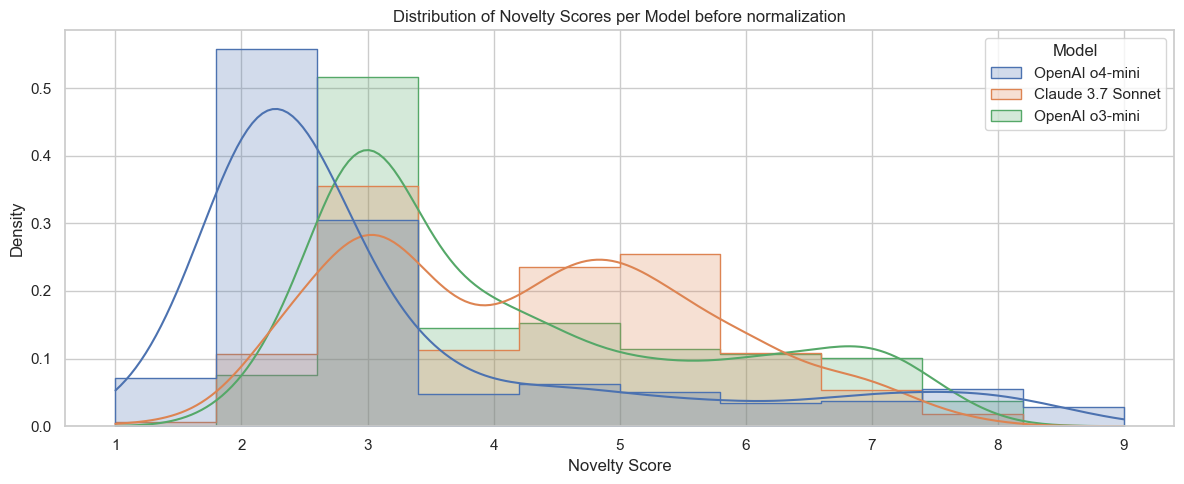

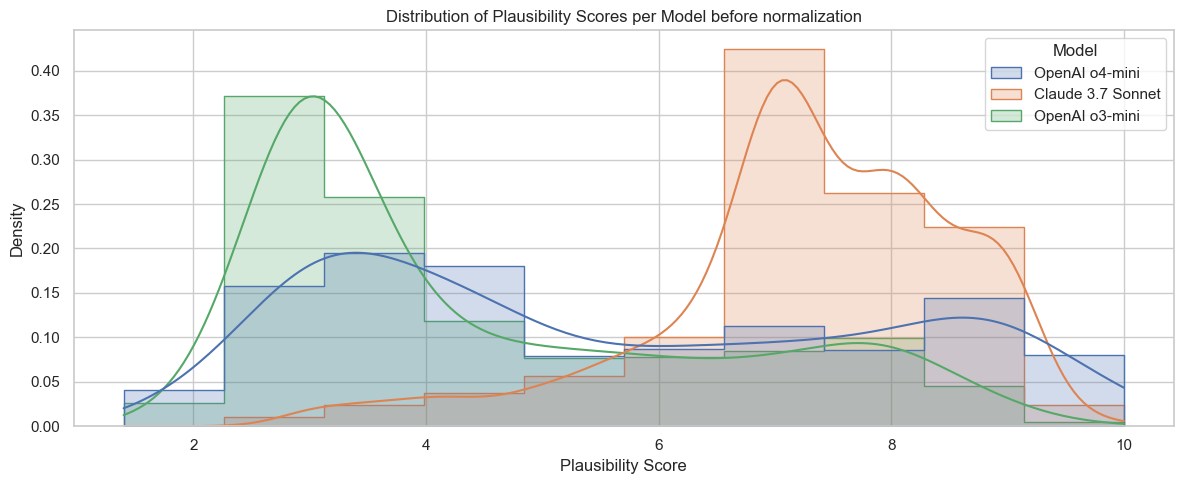

In [141]:
#distribution before normalization
# df = merged_df.copy()
df['model'] = df['model'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Novelty distribution
plt.figure(figsize=(12, 5))
plot1 = sns.histplot(data=df, x="novelty", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Novelty Scores per Model before normalization")
plt.xlabel("Novelty Score")
plt.ylabel("Density")
plot1.legend_.set_title("Model")  # Explicitly set legend title
plt.tight_layout()
plt.show()

# Plausibility distribution
plt.figure(figsize=(12, 5))
plot2 = sns.histplot(data=df, x="plausibility", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Plausibility Scores per Model before normalization")
plt.xlabel("Plausibility Score")
plt.ylabel("Density")
plot2.legend_.set_title("Model")
plt.tight_layout()
plt.show()

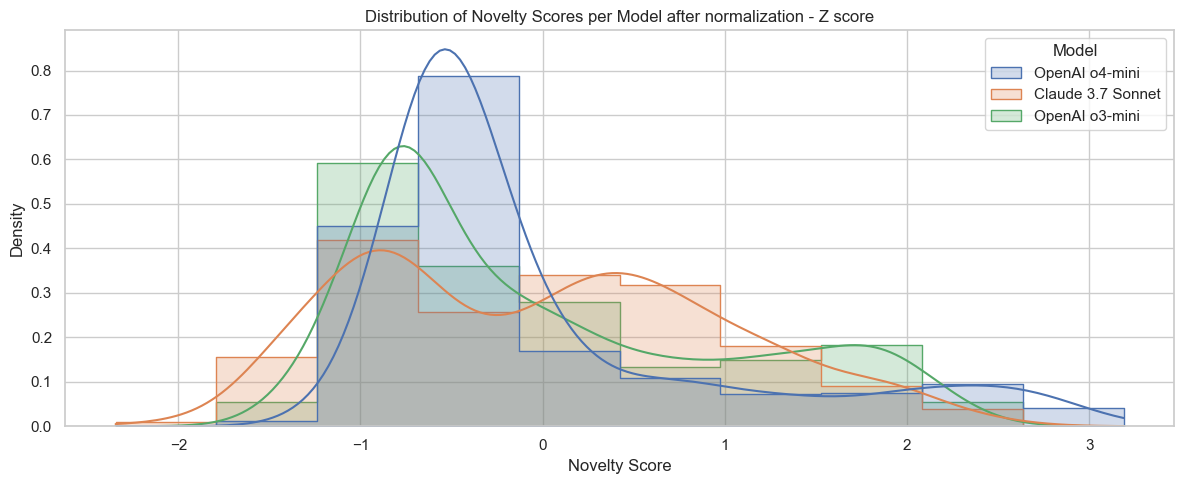

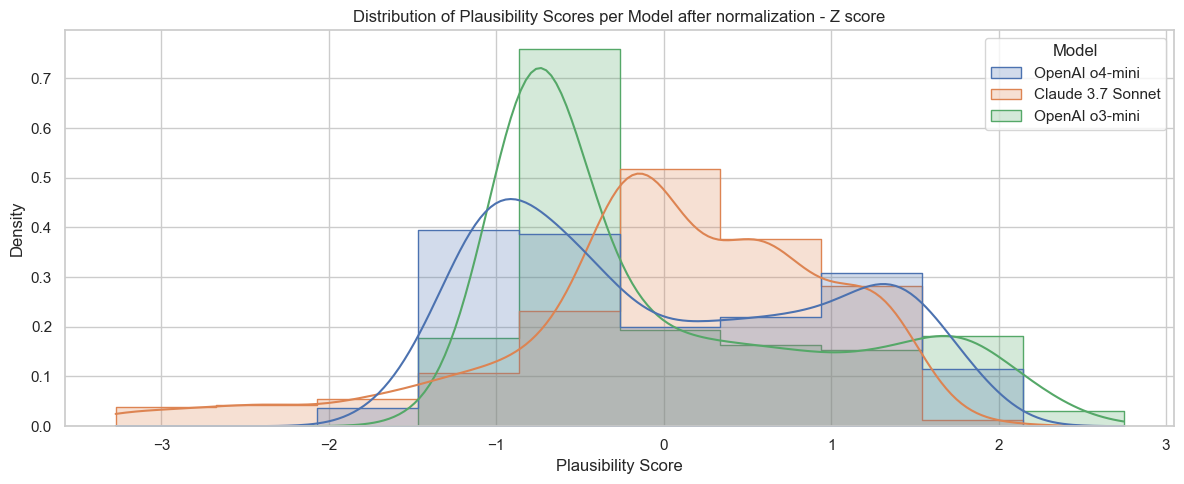

In [142]:
# Ensure 'model' is treated as a categorical variable
# df = merged_df.copy()
df['model'] = df['model'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Novelty distribution
plt.figure(figsize=(12, 5))
plot1 = sns.histplot(data=df, x="novelty_norm", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Novelty Scores per Model after normalization - Z score")
plt.xlabel("Novelty Score")
plt.ylabel("Density")
plot1.legend_.set_title("Model")  # Explicitly set legend title
plt.tight_layout()
plt.show()

# Plausibility distribution
plt.figure(figsize=(12, 5))
plot2 = sns.histplot(data=df, x="plausibility_norm", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Plausibility Scores per Model after normalization - Z score")
plt.xlabel("Plausibility Score")
plt.ylabel("Density")
plot2.legend_.set_title("Model")
plt.tight_layout()
plt.show()

In [143]:
# Calculate the 90th percentile thresholds
novelty_thresh = df['novelty_norm'].quantile(0.708)
plausibility_thresh = df['plausibility_norm'].quantile(0.708)

# Filter rows that exceed both thresholds
data = df[(df['novelty_norm'] >= novelty_thresh) & (df['plausibility_norm'] >= plausibility_thresh)]
data

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,cancer_type,hypo_factors,Codons,Start_Position,...,support,method,Unnamed: 0,Position,VAR_TYPE_SX,rank,frameshift_variant,stop_gained,novelty_norm,plausibility_norm
14744,XGBS.BREAST_CARCINOMA.359,OpenAI o3-mini,5.6,6.4,2.073644,0.894427,Breast Carcinoma,Sex value is Female AND Event Info value is MA...,NaN,NaN,...,4.00,XGBS,NaN,NaN,NaN,359,0,0,0.919618,0.996087
4707,LGBM.BREAST_CARCINOMA.277,Claude 3.7 Sonnet,6.0,8.2,0.707107,0.447214,Breast Carcinoma,TMB (nonsynonymous) value is 0.2 AND Sex value...,NaN,NaN,...,6.00,LGBM,NaN,NaN,NaN,277,0,0,1.230196,0.710710
4984,LGBM.NON_SMALL_CELL_LUNG_CANCER.366,OpenAI o4-mini,4.8,8.6,2.167948,0.547723,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.133333333 AND E...,NaN,NaN,...,5.00,LGBM,NaN,NaN,NaN,366,0,0,0.864980,1.307390
1239,LGBM.INTRAHEPATIC_CHOLANGIOCARCINOMA.416,Claude 3.7 Sonnet,5.2,8.0,1.303840,0.000000,Intrahepatic Cholangiocarcinoma,TMB (nonsynonymous) value is 0.166666667 AND D...,NaN,NaN,...,4.00,LGBM,NaN,NaN,NaN,416,0,0,0.658299,0.557485
4704,LGBM.NON_SMALL_CELL_LUNG_CANCER.274,Claude 3.7 Sonnet,5.4,8.0,0.894427,0.000000,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is PRKDC AND Smoke Sta...,NaN,NaN,...,7.00,LGBM,NaN,NaN,NaN,274,0,0,0.801274,0.557485
11752,LGBM.NON_SMALL_CELL_LUNG_CANCER.36,Claude 3.7 Sonnet,5.8,8.0,1.095445,0.000000,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.9 AND Site2 Hug...,NaN,NaN,...,28.00,LGBM,NaN,NaN,NaN,36,0,0,1.087222,0.557485
11887,LGBM.NON_SMALL_CELL_LUNG_CANCER.81,Claude 3.7 Sonnet,5.8,8.0,0.836660,0.000000,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.6 AND Site2 Hug...,NaN,NaN,...,19.00,LGBM,NaN,NaN,NaN,81,0,0,1.087222,0.557485
17460,LIFT.GALLBLADDER_CARCINOMA.12,Claude 3.7 Sonnet,7.0,8.0,0.000000,0.000000,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 12...,NaN,NaN,...,12.42,LIFT,1428.0,NaN,Truncation,12,0,0,1.945066,0.557485
3435,XGBS.COLORECTAL_CARCINOMA.475,Claude 3.7 Sonnet,6.2,8.0,0.836660,0.000000,Colorectal Carcinoma,Codons value is gGt/gAt AND End Position value...,gGt/gAt,NaN,...,3.00,XGBS,NaN,NaN,NaN,475,0,0,1.373170,0.557485
19266,XGBS.NON_SMALL_CELL_LUNG_CANCER.574,Claude 3.7 Sonnet,6.6,8.0,0.547723,0.000000,Non Small Cell Lung Cancer,Site1 Hugo Symbol value is NTRK3 AND Smoke Sta...,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,574,0,0,1.659118,0.557485


In [144]:
data = df[(df["novelty_norm"] > 1) & (df["plausibility_norm"] > 0.5)]
data = data.drop(columns=['novelty_norm', 'plausibility_norm', 'Unnamed: 0', 'rank'])
data['novelty'] = None
data['plausibility'] = None
data

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,cancer_type,hypo_factors,Codons,Start_Position,...,Site2_Hugo_Symbol,Protein_position,Variant_Type,splice_acceptor_variant,support,method,Position,VAR_TYPE_SX,frameshift_variant,stop_gained
4707,LGBM.BREAST_CARCINOMA.277,Claude 3.7 Sonnet,None,None,0.707107,0.447214,Breast Carcinoma,TMB (nonsynonymous) value is 0.2 AND Sex value...,NaN,NaN,...,ERBB2,NaN,NaN,NaN,6.00,LGBM,NaN,NaN,0,0
11752,LGBM.NON_SMALL_CELL_LUNG_CANCER.36,Claude 3.7 Sonnet,None,None,1.095445,0.000000,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.9 AND Site2 Hug...,NaN,NaN,...,FOXL2,NaN,NaN,NaN,28.00,LGBM,NaN,NaN,0,0
11887,LGBM.NON_SMALL_CELL_LUNG_CANCER.81,Claude 3.7 Sonnet,None,None,0.836660,0.000000,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.6 AND Site2 Hug...,NaN,NaN,...,CCDC149,NaN,NaN,NaN,19.00,LGBM,NaN,NaN,0,0
17460,LIFT.GALLBLADDER_CARCINOMA.12,Claude 3.7 Sonnet,None,None,0.000000,0.000000,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 12...,NaN,NaN,...,NaN,NaN,NaN,NaN,12.42,LIFT,NaN,Truncation,0,0
3435,XGBS.COLORECTAL_CARCINOMA.475,Claude 3.7 Sonnet,None,None,0.836660,0.000000,Colorectal Carcinoma,Codons value is gGt/gAt AND End Position value...,gGt/gAt,NaN,...,NaN,12.0,NaN,NaN,3.00,XGBS,NaN,NaN,0,0
19266,XGBS.NON_SMALL_CELL_LUNG_CANCER.574,Claude 3.7 Sonnet,None,None,0.547723,0.000000,Non Small Cell Lung Cancer,Site1 Hugo Symbol value is NTRK3 AND Smoke Sta...,NaN,NaN,...,FOXN3,NaN,NaN,NaN,3.00,XGBS,NaN,NaN,0,0
9586,LGBM.NON_SMALL_CELL_LUNG_CANCER.608,OpenAI o3-mini,None,None,0.836660,0.836660,Non Small Cell Lung Cancer,Diagnosis Age value is 61-70 AND Site2 Hugo Sy...,NaN,NaN,...,NEK11,NaN,NaN,NaN,3.00,LGBM,NaN,NaN,0,0
15342,XGBS.NON_SMALL_CELL_LUNG_CANCER.562,OpenAI o4-mini,None,None,1.095445,0.836660,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.1 AND Smoke Sta...,NaN,NaN,...,NTRK3,NaN,NaN,NaN,3.00,XGBS,NaN,NaN,0,0
18772,XGBS.LIVER_HEPATOCELLULAR_CARCINOMA.409,OpenAI o3-mini,None,None,0.836660,0.547723,Liver Hepatocellular Carcinoma,Sex value is Male AND Site1 Hugo Symbol value ...,NaN,NaN,...,TERT,NaN,NaN,NaN,4.00,XGBS,NaN,NaN,0,0
3277,XGBS.NON_SMALL_CELL_LUNG_CANCER.421,Claude 3.7 Sonnet,None,None,0.447214,0.447214,Non Small Cell Lung Cancer,Event Info value is ATAD1-PTEN AND Smoke Statu...,NaN,NaN,...,PTEN,NaN,NaN,NaN,4.00,XGBS,NaN,NaN,0,0


In [145]:
data.to_excel("llm_results/normalized_new_results.xlsx", index=False)

In [146]:
# df_michal = pd.read_excel("llm_results/michal_input.xlsx")
df_michal = df.copy()

In [147]:
df_michal.columns
# computing Z score
# df_michal[['novelty_norm_michal', 'plausibility_norm_michal']] = df_michal[['novelty', 'plausibility']].transform(
#     lambda x: (x - x.mean()) / x.std()
# )
# df_michal

Index(['hypothesis_id', 'model', 'novelty', 'plausibility', 'std_novelty',
       'std_plausibility', 'cancer_type', 'hypo_factors', 'Codons',
       'Start_Position', 'Hugo_Symbol', 'End_Position',
       'upstream_gene_variant', 'TMB (nonsynonymous)', 'Sex', 'Event_Info',
       'Site1_Hugo_Symbol', 'missense_variant', 'SNP_event', 'Diagnosis Age',
       'Chromosome', 'Exon_Number', 'Smoke Status', 'Site2_Hugo_Symbol',
       'Protein_position', 'Variant_Type', 'splice_acceptor_variant',
       'support', 'method', 'Unnamed: 0', 'Position', 'VAR_TYPE_SX', 'rank',
       'frameshift_variant', 'stop_gained', 'novelty_norm',
       'plausibility_norm'],
      dtype='object')

In [148]:
# df = df[["hypothesis_id", "model", "novelty_norm", "plausibility_norm"]]
# df_michal = df_michal[["hypothesis_id", "hypo_factors", "cancer_type", "novelty_norm_michal", "plausibility_norm_michal"]]
# df_combined = (pd.merge(df, df_michal, on='hypothesis_id', how='inner'))

In [149]:
# # Calculate correlation
# correlation = df_combined['novelty_norm'].corr(df_combined['novelty_norm_michal'])
# print(f"Correlation: {correlation:.2f}")
#
# # Calculate MAE
# mae = mean_absolute_error(df_combined['novelty_norm'], df_combined['novelty_norm_michal'])
# print(f"Mean Absolute Error: {mae:.2f}")


In [167]:
full_data = pd.read_csv("narrowed_cancers_data.csv")
full_data.columns
# full_data = full_data.drop('_tmpkey', axis=1)

Index(['PATIENT_ID', 'Cancer Type', 'Cancer Type Detailed', 'Tumor Stage',
       'Sample Type', 'Sex', 'Diagnosis Age', 'Smoke Status',
       'TMB (nonsynonymous)', 'Hugo_Symbol', 'Chromosome', 'Start_Position',
       'End_Position', 'Variant_Type', 'SNP_event', 'Protein_position',
       'Codons', 'Exon_Number', 'VAR_TYPE_SX', 'Site1_Hugo_Symbol',
       'Site2_Hugo_Symbol', 'Event_Info', '3_prime_UTR_variant',
       '5_prime_UTR_variant', 'NMD_transcript_variant',
       'coding_sequence_variant', 'downstream_gene_variant',
       'frameshift_variant', 'inframe_deletion', 'inframe_insertion',
       'intergenic_variant', 'intron_variant', 'mature_miRNA_variant',
       'missense_variant', 'non_coding_transcript_exon_variant',
       'non_coding_transcript_variant', 'protein_altering_variant',
       'splice_acceptor_variant', 'splice_donor_variant',
       'splice_region_variant', 'start_lost', 'start_retained_variant',
       'stop_gained', 'stop_lost', 'stop_retained_variant',


In [171]:
# Mapping from df_michal to full_data column names
rename_dict = {
    'cancer_type': 'Cancer Type',
    'Diagnosis Age': 'Diagnosis Age',
    'Smoke Status': 'Smoke Status',
    'TMB (nonsynonymous)': 'TMB (nonsynonymous)',
    'Hugo_Symbol': 'Hugo_Symbol',
    'Chromosome': 'Chromosome',
    'Start_Position': 'Start_Position',
    'End_Position': 'End_Position',
    'Variant_Type': 'Variant_Type',
    'SNP_event': 'SNP_event',
    'Protein_position': 'Protein_position',
    'Codons': 'Codons',
    'Exon_Number': 'Exon_Number',
    'VAR_TYPE_SX': 'VAR_TYPE_SX',
    'Site1_Hugo_Symbol': 'Site1_Hugo_Symbol',
    'Site2_Hugo_Symbol': 'Site2_Hugo_Symbol',
    'Event_Info': 'Event_Info',
    'missense_variant': 'missense_variant',
    'Sex': 'Sex',
    'splice_acceptor_variant': 'splice_acceptor_variant',
    'upstream_gene_variant': 'upstream_gene_variant'
    # Add more mappings if needed
}

# Rename columns in df_michal
df_michal = df.copy()
df_michal_renamed = df_michal.rename(columns=rename_dict)
df_michal_renamed

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,Cancer Type,hypo_factors,Codons,Start_Position,...,support,method,Unnamed: 0,Position,VAR_TYPE_SX,rank,frameshift_variant,stop_gained,novelty_norm,plausibility_norm
15025,XGBS.SOFT_TISSUE_SARCOMA.455,OpenAI o4-mini,9.0,2.0,0.707107,0.000000,Soft Tissue Sarcoma,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,NaN,NaN,...,4.00,XGBS,NaN,NaN,NaN,455,0,0,3.189211,-1.509796
16640,LGBM.NON_SMALL_CELL_LUNG_CANCER.371,OpenAI o4-mini,7.4,4.4,1.140175,1.140175,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,NaN,NaN,...,5.00,LGBM,NaN,NaN,NaN,371,0,0,2.303790,-0.485365
2763,XGBS.COLORECTAL_CARCINOMA.250,OpenAI o4-mini,8.4,5.4,0.547723,0.894427,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.333333333 AND E...,NaN,NaN,...,6.00,XGBS,NaN,NaN,NaN,250,0,0,2.857178,-0.058518
15207,XGBS.GASTRIC_CANCER.513,OpenAI o4-mini,8.0,5.6,0.707107,0.894427,Gastric Cancer,TMB (nonsynonymous) value is 0.233333333 AND E...,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,513,0,0,2.635823,0.026851
18044,XGBS.NON_SMALL_CELL_LUNG_CANCER.166,OpenAI o4-mini,8.4,4.2,0.894427,1.095445,Non Small Cell Lung Cancer,Event Info value is NOTCH2-LIN28A AND Smoke St...,NaN,NaN,...,10.00,XGBS,NaN,NaN,NaN,166,0,0,2.857178,-0.570734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15776,LGBM.NON_SMALL_CELL_LUNG_CANCER.83,OpenAI o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Diagnosis Age value is 51-60 AND Sex value is ...,NaN,NaN,...,19.00,LGBM,NaN,NaN,NaN,83,0,0,-1.237897,1.819606
17513,LIFT.NON_SMALL_CELL_LUNG_CANCER.29,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Chromosome value is 7 ...,cTg/cGg,NaN,...,3.13,LIFT,2403.0,55259515.0-55259515.0,Substitution/Indel,29,0,0,-1.237897,1.904975
18560,XGBS.NON_SMALL_CELL_LUNG_CANCER.338,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Diagnosis Age value is...,NaN,NaN,...,5.00,XGBS,NaN,NaN,NaN,338,0,0,-1.237897,1.904975
19187,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,OpenAI o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,547,0,0,-1.237897,1.819606


In [232]:
data_for_lift = pd.read_csv("data_for_lift.csv")

In [233]:
matched_rows = []

for _, small_row in df_michal_renamed.iterrows():
    if small_row.get('method') == 'LIFT':
        data_source = data_for_lift
    else:
        data_source = full_data

    # Compute common columns for this data_source
    common_cols = list(set(df_michal_renamed.columns) & set(data_source.columns))

    mask = np.ones(len(data_source), dtype=bool)
    for col in common_cols:
        val = small_row[col]
        mask &= (
            (data_source[col] == val) |
            pd.isna(val)
        ) & (~(pd.notna(val) & data_source[col].isna()))

    filtered = data_source[mask].copy()
    for col in df_michal_renamed.columns:
        filtered[col] = small_row[col]

    if filtered.empty:
        # Add the unmatched row with NaN for data_source columns
        unmatched_row = pd.DataFrame([small_row], columns=df_michal_renamed.columns)
        for col in data_source.columns:
            if col not in unmatched_row.columns:
                unmatched_row[col] = np.nan
        matched_rows.append(unmatched_row)
    else:
        matched_rows.append(filtered)

result = pd.concat(matched_rows, ignore_index=True) if matched_rows else pd.DataFrame()


# # Split by method
# lift_rows = df_michal_renamed[df_michal_renamed['method'] == 'LIFT']
# other_rows = df_michal_renamed[df_michal_renamed['method'] != 'LIFT']
#
# def smart_merge(left, right):
#     common_cols = list(set(left.columns) & set(right.columns))
#     merged = left.merge(right, on=common_cols, how='left', suffixes=('', '_right'))
#     return merged
#
# # Merge for LIFT
# if not lift_rows.empty:
#     lift_result = smart_merge(lift_rows, full_data_lift)
# else:
#     lift_result = pd.DataFrame()
#
# # Merge for others
# if not other_rows.empty:
#     other_result = smart_merge(other_rows, full_data)
# else:
#     other_result = pd.DataFrame()
#
# # Combine results
# result = pd.concat([lift_result, other_result], ignore_index=True)

In [246]:
tal = data_for_lift[data_for_lift["Diagnosis Age"] == "41-50"]
tal = tal[tal["Sex"] == "Female"]
tal = tal[tal["TMB (nonsynonymous)"] == 0.166666667]
# tal = tal[tal["Hugo_Symbol"] == "KRAS"]
# tal = tal[tal["Chromosome"] == "12"]
# tal = tal[tal['SNP_event'] == "C>A"]
# tal = tal[tal["Protein_position"] == 249.0]
tal = tal[tal["Cancer Type"] == "Intrahepatic Cholangiocarcinoma"]
tal

,PATIENT_ID,Cancer Type,Cancer Type Detailed,Tumor Stage,Sample Type,Sex,Diagnosis Age,Smoke Status,TMB (nonsynonymous),Hugo_Symbol,...,Extrahepatic Cholangiocarcinoma,Gallbladder Carcinoma,Gastric Cancer,Intrahepatic Cholangiocarcinoma,Liver Hepatocellular Carcinoma,Non Small Cell Lung Cancer,Pancreatic Cancer,Small Cell Lung Cancer,Soft Tissue Sarcoma,Position
1074,Patient0113,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,II,Primary,Female,41-50,Unknown,0.166667,EPHA2,...,0,0,0,1,0,0,0,0,0,16459848.0-16459848.0
1075,Patient0113,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,II,Primary,Female,41-50,Unknown,0.166667,TP53,...,0,0,0,1,0,0,0,0,0,7577538.0-7577538.0
1076,Patient0113,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,II,Primary,Female,41-50,Unknown,0.166667,GNA13,...,0,0,0,1,0,0,0,0,0,63010698.0-63010698.0
1077,Patient0113,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,II,Primary,Female,41-50,Unknown,0.166667,IDH1,...,0,0,0,1,0,0,0,0,0,209113113.0-209113113.0
1078,Patient0113,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,II,Primary,Female,41-50,Unknown,0.166667,ARID1A,...,0,0,0,1,0,0,0,0,0,27101695.0-27101696.0
10403,Patient10034,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,III,Primary,Female,41-50,Unknown,0.166667,PREX2,...,0,0,0,1,0,0,0,0,0,68992692.0-68992692.0
10404,Patient10034,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,III,Primary,Female,41-50,Unknown,0.166667,PIK3C2B,...,0,0,0,1,0,0,0,0,0,204399048.0-204399048.0
10405,Patient10034,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,III,Primary,Female,41-50,Unknown,0.166667,NTRK3,...,0,0,0,1,0,0,0,0,0,88483996.0-88483996.0
10406,Patient10034,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,III,Primary,Female,41-50,Unknown,0.166667,TP53,...,0,0,0,1,0,0,0,0,0,7578270.0-7578270.0
10407,Patient10034,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,III,Primary,Female,41-50,Unknown,0.166667,IGF1R,...,0,0,0,1,0,0,0,0,0,99456317.0-99456317.0


In [234]:
r = result[result["method"] == "LGBM"]
t = df_michal_renamed[df_michal_renamed["method"] == "LGBM"]
len(r["hypothesis_id"].unique())
# len(t["hypothesis_id"].unique())
result[result["PATIENT_ID"].isna()]
# result["hypothesis_id"].unique().shape
# df_michal_renamed["hypothesis_id"].unique().shape

,PATIENT_ID,Cancer Type,Cancer Type Detailed,Tumor Stage,Sample Type,Sex,Diagnosis Age,Smoke Status,TMB (nonsynonymous),Hugo_Symbol,...,Esophageal Carcinoma,Extrahepatic Cholangiocarcinoma,Gallbladder Carcinoma,Gastric Cancer,Intrahepatic Cholangiocarcinoma,Liver Hepatocellular Carcinoma,Non Small Cell Lung Cancer,Pancreatic Cancer,Small Cell Lung Cancer,Soft Tissue Sarcoma
162,NaN,Intrahepatic Cholangiocarcinoma,NaN,NaN,NaN,Female,41-50,NaN,0.166667,KRAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,NaN,Liver Hepatocellular Carcinoma,NaN,NaN,NaN,Male,51-60,NaN,0.233333,NFE2L2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
864,NaN,Pancreatic Cancer,NaN,NaN,NaN,Female,61-70,NaN,NaN,KRAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1447,NaN,Colorectal Carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMER1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1665,NaN,Gastric Cancer,NaN,NaN,NaN,Male,NaN,NaN,NaN,CIC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189828,NaN,Colorectal Carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189829,NaN,Colorectal Carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189830,NaN,Colorectal Carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189870,NaN,Colorectal Carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
result.drop_duplicates(inplace=True)
counts = result.groupby('hypothesis_id')['PATIENT_ID'].nunique()
counts

hypothesis_id
LGBM.BREAST_CARCINOMA.112        1
LGBM.BREAST_CARCINOMA.155        1
LGBM.BREAST_CARCINOMA.248        1
LGBM.BREAST_CARCINOMA.277        1
LGBM.BREAST_CARCINOMA.318       19
                                ..
XGBS.SOFT_TISSUE_SARCOMA.617     1
XGBS.SOFT_TISSUE_SARCOMA.618     1
XGBS.SOFT_TISSUE_SARCOMA.619     3
XGBS.SOFT_TISSUE_SARCOMA.620     1
XGBS.SOFT_TISSUE_SARCOMA.621     1
Name: PATIENT_ID, Length: 1210, dtype: int64

In [156]:
# Compute unique PATIENT_ID count per hypothesis_id
patient_counts = result.groupby('hypothesis_id')['PATIENT_ID'].nunique().reset_index()
patient_counts.rename(columns={'PATIENT_ID': 'unique_patient_count'}, inplace=True)

# Merge into df_michal_renamed
df_michal_renamed = df_michal_renamed.merge(patient_counts, on='hypothesis_id', how='left')

In [157]:
df_michal_renamed.sort_values(by=["novelty", 'unique_patient_count', "plausibility"], ascending=[False, False, False], inplace=True)
df_michal_renamed

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,Cancer Type,hypo_factors,Codons,Start_Position,...,method,Unnamed: 0,Position,VAR_TYPE_SX,rank,frameshift_variant,stop_gained,novelty_norm,plausibility_norm,unique_patient_count
29,XGBS.BREAST_CARCINOMA.458,OpenAI o4-mini,9.0,2.8,0.000000,0.447214,Breast Carcinoma,Sex value is Female AND Event Info value is PM...,NaN,NaN,...,XGBS,NaN,NaN,NaN,458,0,0,3.189211,-1.168319,1.0
0,XGBS.SOFT_TISSUE_SARCOMA.455,OpenAI o4-mini,9.0,2.0,0.707107,0.000000,Soft Tissue Sarcoma,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,NaN,NaN,...,XGBS,NaN,NaN,NaN,455,0,0,3.189211,-1.509796,1.0
46,XGBS.NON_SMALL_CELL_LUNG_CANCER.165,OpenAI o4-mini,8.8,2.0,0.447214,0.000000,Non Small Cell Lung Cancer,Event Info value is MEN1-SBDS AND Smoke Status...,NaN,NaN,...,XGBS,NaN,NaN,NaN,165,0,0,3.078534,-1.509796,1.0
15,XGBS.NON_SMALL_CELL_LUNG_CANCER.563,OpenAI o4-mini,8.6,3.8,0.547723,0.447214,Non Small Cell Lung Cancer,Event Info value is MICAL3-PDGFB AND Smoke Sta...,NaN,NaN,...,XGBS,NaN,NaN,NaN,563,0,0,2.967856,-0.741473,1.0
45,XGBS.GASTRIC_CANCER.176,OpenAI o4-mini,8.6,3.0,0.547723,1.414214,Gastric Cancer,TMB (nonsynonymous) value is 0.333333333 AND E...,NaN,NaN,...,XGBS,NaN,NaN,NaN,176,0,0,2.967856,-1.082950,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,LGBM.NON_SMALL_CELL_LUNG_CANCER.435,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Protein position value is 858.0 AND Hugo Symbo...,NaN,NaN,...,LGBM,NaN,NaN,NaN,435,0,0,-1.237897,1.904975,82.0
3880,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,OpenAI o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,...,XGBS,NaN,NaN,NaN,547,0,0,-1.237897,1.819606,82.0
3875,LGBM.NON_SMALL_CELL_LUNG_CANCER.169,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Event Info value is EML4-ALK AND Site2 Hugo Sy...,NaN,NaN,...,LGBM,NaN,NaN,NaN,169,0,0,-1.237897,1.904975,59.0
3879,XGBS.NON_SMALL_CELL_LUNG_CANCER.338,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Diagnosis Age value is...,NaN,NaN,...,XGBS,NaN,NaN,NaN,338,0,0,-1.237897,1.904975,7.0


In [158]:
dd = df_michal_renamed[df_michal_renamed["unique_patient_count"] > 3]
dd

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,Cancer Type,hypo_factors,Codons,Start_Position,...,method,Unnamed: 0,Position,VAR_TYPE_SX,rank,frameshift_variant,stop_gained,novelty_norm,plausibility_norm,unique_patient_count
353,XGBS.NON_SMALL_CELL_LUNG_CANCER.327,Claude 3.7 Sonnet,7.6,3.0,0.547723,0.000000,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.2 AND Chromosom...,NaN,NaN,...,XGBS,NaN,NaN,NaN,327,0,0,2.373988,-3.273152,18.0
151,LGBM.NON_SMALL_CELL_LUNG_CANCER.436,Claude 3.7 Sonnet,7.4,3.4,0.547723,0.547723,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.1 AND SNP event...,NaN,NaN,...,LGBM,NaN,NaN,NaN,436,0,0,2.231014,-2.966701,16.0
302,XGBS.COLORECTAL_CARCINOMA.481,OpenAI o3-mini,7.4,2.4,0.547723,0.547723,Colorectal Carcinoma,Codons value is Cgc/Tgc AND Sex value is Male ...,Cgc/Tgc,NaN,...,XGBS,NaN,NaN,NaN,481,0,0,2.086144,-1.063082,13.0
106,LGBM.NON_SMALL_CELL_LUNG_CANCER.91,Claude 3.7 Sonnet,7.0,5.2,0.707107,1.643168,Non Small Cell Lung Cancer,Diagnosis Age value is 41-50 AND SNP event val...,NaN,NaN,...,LGBM,NaN,NaN,NaN,91,0,0,1.945066,-1.587672,50.0
182,XGBS.NON_SMALL_CELL_LUNG_CANCER.336,Claude 3.7 Sonnet,7.0,5.6,0.707107,1.140175,Non Small Cell Lung Cancer,SNP event value is C>A AND Chromosome value is...,NaN,NaN,...,XGBS,NaN,NaN,NaN,336,0,0,1.945066,-1.281221,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,LGBM.COLORECTAL_CARCINOMA.320,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Colorectal Carcinoma,Protein position value is 12.0 AND Codons valu...,gGt/gTt,NaN,...,LGBM,NaN,NaN,NaN,320,0,0,-1.237897,1.904975,104.0
3876,LGBM.NON_SMALL_CELL_LUNG_CANCER.435,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Protein position value is 858.0 AND Hugo Symbo...,NaN,NaN,...,LGBM,NaN,NaN,NaN,435,0,0,-1.237897,1.904975,82.0
3880,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,OpenAI o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,...,XGBS,NaN,NaN,NaN,547,0,0,-1.237897,1.819606,82.0
3875,LGBM.NON_SMALL_CELL_LUNG_CANCER.169,OpenAI o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Event Info value is EML4-ALK AND Site2 Hugo Sy...,NaN,NaN,...,LGBM,NaN,NaN,NaN,169,0,0,-1.237897,1.904975,59.0


In [159]:
df_michal_renamed[df_michal_renamed["hypothesis_id"].str.startswith("LIFT")]

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,Cancer Type,hypo_factors,Codons,Start_Position,...,method,Unnamed: 0,Position,VAR_TYPE_SX,rank,frameshift_variant,stop_gained,novelty_norm,plausibility_norm,unique_patient_count
159,LIFT.BREAST_CARCINOMA.16,OpenAI o4-mini,7.6,3.6,0.547723,0.547723,Breast Carcinoma,Sex value is Female AND Chromosome value is 2 ...,NaN,NaN,...,LIFT,219.0,NaN,Substitution/Indel,16,0,0,2.414468,-0.826842,NaN
108,LIFT.GASTRIC_CANCER.39,OpenAI o4-mini,7.4,5.0,0.894427,1.224745,Gastric Cancer,Sex value is Male AND Chromosome value is 19 A...,gGt/gt,NaN,...,LIFT,1673.0,56435161.0-56435161.0,Truncation,39,1,0,2.303790,-0.229257,NaN
161,LIFT.GALLBLADDER_CARCINOMA.12,OpenAI o3-mini,7.2,3.6,0.836660,0.894427,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 12...,NaN,NaN,...,LIFT,1428.0,NaN,Truncation,12,0,0,1.956530,-0.445331,NaN
162,LIFT.INTRAHEPATIC_CHOLANGIOCARCINOMA.20,OpenAI o3-mini,7.2,3.2,0.447214,0.836660,Intrahepatic Cholangiocarcinoma,Sex value is Male AND Chromosome value is 3 AN...,gGt/gAt,NaN,...,LIFT,1984.0,25398284.0-25398284.0,Truncation,20,0,0,1.956530,-0.651248,NaN
458,LIFT.GALLBLADDER_CARCINOMA.12,Claude 3.7 Sonnet,7.0,8.0,0.000000,0.000000,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 12...,NaN,NaN,...,LIFT,1428.0,NaN,Truncation,12,0,0,1.945066,0.557485,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586,LIFT.BREAST_CARCINOMA.2,OpenAI o4-mini,1.4,9.8,0.547723,0.447214,Breast Carcinoma,Sex value is Female AND Chromosome value is 3 ...,cAt/cGt,NaN,...,LIFT,238.0,178952085.0-178952085.0,Substitution/Indel,2,0,0,-1.016541,1.819606,55.0
3588,LIFT.BREAST_CARCINOMA.8,OpenAI o4-mini,1.4,9.6,0.547723,0.547723,Breast Carcinoma,Sex value is Female AND Chromosome value is 3 ...,cAt/cGt,NaN,...,LIFT,230.0,178952085.0-178952085.0,Substitution/Indel,8,0,0,-1.016541,1.734237,3.0
3593,LIFT.PANCREATIC_CANCER.7,OpenAI o4-mini,1.2,10.0,0.447214,0.000000,Pancreatic Cancer,Sex value is Male AND Chromosome value is 12 A...,gGt/gTt,NaN,...,LIFT,2835.0,25398284.0-25398284.0,Substitution/Indel,7,0,0,-1.127219,1.904975,29.0
3709,LIFT.COLORECTAL_CARCINOMA.36,OpenAI o4-mini,1.2,9.8,0.447214,0.447214,Colorectal Carcinoma,Sex value is Female AND Chromosome value is 5 ...,Cga/Tga,NaN,...,LIFT,472.0,112175639.0-112175639.0,Truncation,36,0,1,-1.127219,1.819606,3.0


In [160]:
data = dd[(dd["novelty_norm"] > 0.9) & (dd["plausibility_norm"] > -0.3)]
data = data.drop(columns=['novelty_norm', 'plausibility_norm', 'Unnamed: 0', 'rank'])
# data['novelty'] = None
# data['plausibility'] = None
data

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,Cancer Type,hypo_factors,Codons,Start_Position,...,Protein_position,Variant_Type,splice_acceptor_variant,support,method,Position,VAR_TYPE_SX,frameshift_variant,stop_gained,unique_patient_count
58,LIFT.GALLBLADDER_CARCINOMA.17,OpenAI o4-mini,6.8,5.6,0.836660,1.140175,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 5 ...,NaN,NaN,...,NaN,NaN,NaN,9.2,LIFT,NaN,Substitution/Indel,0,0,20.0
468,XGBS.COLORECTAL_CARCINOMA.475,Claude 3.7 Sonnet,6.2,8.0,0.836660,0.000000,Colorectal Carcinoma,Codons value is gGt/gAt AND End Position value...,gGt/gAt,NaN,...,12.0,NaN,NaN,3.0,XGBS,NaN,NaN,0,0,39.0
253,LGBM.NON_SMALL_CELL_LUNG_CANCER.265,OpenAI o3-mini,6.2,4.0,2.489980,2.236068,Non Small Cell Lung Cancer,Start Position value is 55242465.0 AND TMB (no...,NaN,55242465.0,...,NaN,NaN,NaN,7.0,LGBM,NaN,NaN,0,0,16.0
1086,LGBM.LIVER_HEPATOCELLULAR_CARCINOMA.163,Claude 3.7 Sonnet,6.0,7.2,0.000000,0.447214,Liver Hepatocellular Carcinoma,TMB (nonsynonymous) value is 0.3 AND Sex value...,NaN,NaN,...,NaN,NaN,NaN,11.0,LGBM,NaN,NaN,0,0,24.0
469,XGBS.COLORECTAL_CARCINOMA.483,Claude 3.7 Sonnet,5.8,7.4,0.836660,0.547723,Colorectal Carcinoma,TMB (nonsynonymous) value is 0.333333333 AND S...,NaN,NaN,...,12.0,NaN,NaN,3.0,XGBS,NaN,NaN,0,0,10.0
1074,LGBM.COLORECTAL_CARCINOMA.490,Claude 3.7 Sonnet,5.8,8.0,0.447214,0.000000,Colorectal Carcinoma,Codons value is Cgg/Tgg AND Diagnosis Age valu...,Cgg/Tgg,NaN,...,NaN,NaN,NaN,3.0,LGBM,NaN,NaN,0,0,7.0
497,XGBS.NON_SMALL_CELL_LUNG_CANCER.88,Claude 3.7 Sonnet,5.6,7.2,2.073644,0.836660,Non Small Cell Lung Cancer,Sex value is Male AND SNP event value is G>T A...,NaN,NaN,...,NaN,NaN,NaN,16.0,XGBS,NaN,NaN,0,0,127.0
1358,XGBS.PANCREATIC_CANCER.613,Claude 3.7 Sonnet,5.6,7.2,0.547723,0.447214,Pancreatic Cancer,TMB (nonsynonymous) value is 0.233333333 AND D...,NaN,NaN,...,12.0,NaN,NaN,3.0,XGBS,NaN,NaN,0,0,9.0
1225,LGBM.ESOPHAGEAL_CARCINOMA.402,Claude 3.7 Sonnet,5.6,7.0,0.547723,0.000000,Esophageal Carcinoma,TMB (nonsynonymous) value is 0.466666667 AND D...,NaN,NaN,...,NaN,NaN,NaN,4.0,LGBM,NaN,NaN,0,0,7.0


In [161]:
df_michal = pd.read_excel("llm_results/michal_input.xlsx")
merged = data.merge(df_michal, on='hypothesis_id', how='left')
merged[["hypothesis_id", "model", "hypo_factors_x", "cancer_type","novelty_x", "plausibility_x", "novelty_y", "plausibility_y", "unique_patient_count", "comments"]].drop_duplicates()

,hypothesis_id,model,hypo_factors_x,cancer_type,novelty_x,plausibility_x,novelty_y,plausibility_y,unique_patient_count,comments
0,LIFT.GALLBLADDER_CARCINOMA.17,OpenAI o4-mini,Sex value is Female AND Chromosome value is 5 ...,Gallbladder Carcinoma,6.8,5.6,6.0,10.0,20.0,"why only females, why gall bladder -not clear..."
1,XGBS.COLORECTAL_CARCINOMA.475,Claude 3.7 Sonnet,Codons value is gGt/gAt AND End Position value...,Colorectal Carcinoma,6.2,8.0,2.0,10.0,39.0,the exact known KRAS mutation in aa 12
2,LGBM.NON_SMALL_CELL_LUNG_CANCER.265,OpenAI o3-mini,Start Position value is 55242465.0 AND TMB (no...,NaN,6.2,4.0,NaN,NaN,16.0,NaN
3,LGBM.LIVER_HEPATOCELLULAR_CARCINOMA.163,Claude 3.7 Sonnet,TMB (nonsynonymous) value is 0.3 AND Sex value...,NaN,6.0,7.2,NaN,NaN,24.0,NaN
4,XGBS.COLORECTAL_CARCINOMA.483,Claude 3.7 Sonnet,TMB (nonsynonymous) value is 0.333333333 AND S...,Colorectal Carcinoma,5.8,7.4,2.0,8.0,10.0,non specific annotation -it is a result of the...
5,LGBM.COLORECTAL_CARCINOMA.490,Claude 3.7 Sonnet,Codons value is Cgg/Tgg AND Diagnosis Age valu...,Colorectal Carcinoma,5.8,8.0,4.0,8.0,7.0,seems generic. TP53 (tumor protein p53) The Cg...
6,XGBS.NON_SMALL_CELL_LUNG_CANCER.88,Claude 3.7 Sonnet,Sex value is Male AND SNP event value is G>T A...,Non Small Cell Lung Cancer,5.6,7.2,6.0,8.0,127.0,"too broad, maybe related to minimal missense c..."
7,XGBS.PANCREATIC_CANCER.613,Claude 3.7 Sonnet,TMB (nonsynonymous) value is 0.233333333 AND D...,NaN,5.6,7.2,NaN,NaN,9.0,NaN
8,LGBM.ESOPHAGEAL_CARCINOMA.402,Claude 3.7 Sonnet,TMB (nonsynonymous) value is 0.466666667 AND D...,NaN,5.6,7.0,NaN,NaN,7.0,NaN


In [162]:
TMB (nonsynonymous) value is 0.3 AND Sex value is Male AND SNP event value is A>T

SyntaxError: invalid syntax (2731974937.py, line 1)

In [152]:
df[df["rank"] == 163]

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,cancer_type,hypo_factors,Codons,Start_Position,...,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm
4370,LGBM.LIVER_HEPATOCELLULAR_CARCINOMA.163,openai:o3-mini,5.2,3.0,2.049390,0.000000,Liver Hepatocellular Carcinoma,TMB (nonsynonymous) value is 0.3 AND Sex value...,NaN,NaN,...,NaN,11.0,LGBM,NaN,NaN,NaN,NaN,163,0.660390,-0.754206
12126,LGBM.LIVER_HEPATOCELLULAR_CARCINOMA.163,anthropic:claude-3-7-sonnet-latest,6.0,7.2,0.000000,0.447214,Liver Hepatocellular Carcinoma,TMB (nonsynonymous) value is 0.3 AND Sex value...,NaN,NaN,...,NaN,11.0,LGBM,NaN,NaN,NaN,NaN,163,1.230196,-0.055417
18033,XGBS.NON_SMALL_CELL_LUNG_CANCER.163,anthropic:claude-3-7-sonnet-latest,4.0,8.0,0.707107,0.000000,Non Small Cell Lung Cancer,Event Info value is LRP1B-Intragenic AND Smoke...,NaN,NaN,...,NaN,10.0,XGBS,NaN,NaN,NaN,NaN,163,-0.199545,0.557485
10270,XGBS.NON_SMALL_CELL_LUNG_CANCER.163,openai:o3-mini,3.6,7.0,0.547723,0.707107,Non Small Cell Lung Cancer,Event Info value is LRP1B-Intragenic AND Smoke...,NaN,NaN,...,NaN,10.0,XGBS,NaN,NaN,NaN,NaN,163,-0.376522,1.304963
18035,XGBS.NON_SMALL_CELL_LUNG_CANCER.163,openai:o4-mini,2.8,8.2,0.447214,0.447214,Non Small Cell Lung Cancer,Event Info value is LRP1B-Intragenic AND Smoke...,NaN,NaN,...,NaN,10.0,XGBS,NaN,NaN,NaN,NaN,163,-0.241797,1.136652
16016,LGBM.LIVER_HEPATOCELLULAR_CARCINOMA.163,openai:o4-mini,2.4,3.0,0.547723,0.000000,Liver Hepatocellular Carcinoma,TMB (nonsynonymous) value is 0.3 AND Sex value...,NaN,NaN,...,NaN,11.0,LGBM,NaN,NaN,NaN,NaN,163,-0.463153,-1.082950
